## ElasticFDSG 2D Demo

This script showcases how to setup, run and visualize results of a 2D simulation. 

For demonstration purposes, we will restrict ourself to a simply layered velocity model.

#### Content

- Create velocity model file 

- Create configuration file 

- Run simulation 

- Load results 

- Visualize results

In [1]:
# Import dependencies
using ElasticFDSG 

using JLD2, YAML  # read and write 
using GLMakie     # visualization 
Makie.inline!(true) 

# Set some paths
VELMODPATH = joinpath(@__DIR__, "velmod.jld2")
CONFIGPATH = joinpath(@__DIR__, "config.yaml")
RESULTPATH = joinpath(@__DIR__, "results")
RESULTFILE = RESULTPATH * ".h5";

┌ Warning: HIP library is unavailable, HIP integration will be disabled.
└ @ AMDGPU ~/.julia/packages/AMDGPU/Zmbiq/src/AMDGPU.jl:187
┌ Warning: rocBLAS is unavailable, functionality will be disabled.
└ @ AMDGPU ~/.julia/packages/AMDGPU/Zmbiq/src/AMDGPU.jl:198
┌ Warning: rocSPARSE is unavailable, functionality will be disabled.
└ @ AMDGPU ~/.julia/packages/AMDGPU/Zmbiq/src/AMDGPU.jl:198
┌ Warning: rocSOLVER is unavailable, functionality will be disabled.
└ @ AMDGPU ~/.julia/packages/AMDGPU/Zmbiq/src/AMDGPU.jl:198
┌ Warning: rocRAND is unavailable, functionality will be disabled.
└ @ AMDGPU ~/.julia/packages/AMDGPU/Zmbiq/src/AMDGPU.jl:198
┌ Warning: rocFFT is unavailable, functionality will be disabled.
└ @ AMDGPU ~/.julia/packages/AMDGPU/Zmbiq/src/AMDGPU.jl:198
┌ Warning: MIOpen is unavailable, functionality will be disabled.
└ @ AMDGPU ~/.julia/packages/AMDGPU/Zmbiq/src/AMDGPU.jl:198
┌ Warning: HIP library is unavailable, HIP integration will be disabled.
└ @ AMDGPU /Users/williamtegto

### Create velocity model file

In [2]:
# grid (nx, nz)
h = 5
xcoords = 0:h:1000;
zcoords = 0:h:1000;
nx, nz = length(xcoords), length(zcoords);
dim = (nx, nz); # model dimensions 

# 2D meshgrid coordinates
X = repeat(xcoords,  1, nz);
Z = repeat(reshape(zcoords, 1, :), nx, 1)

vp = zeros(dim);   # P-wave velocity
vs = zeros(dim);   # S-wave velocity
rho = zeros(dim);  # Density
eps = zeros(dim);  # 2D Thomson parameter epsilon
del = zeros(dim);  # 2D Thomson parameter delta

# fill arrays with values
vp[:,begin:40]  .= 3000;  
vp[:,41:end]    .= 4000; # some heterogenity
vs = vp ./ sqrt(3)
rho[:,begin:40] .= 2200;
rho[:,41:end]  .= 2500;

# thomson vti parameter (zero for isotropic medium)
eps[:,:] .= 0.2;
del[:,:] .= -0.1;

# velocity model => (7, nx, nz)
velmod = zeros(7, nx, nz);
# fill with elastic properties
velmod[1,:,:] .= X;
velmod[2,:,:] .= Z;
velmod[3,:,:] .= vp;
velmod[4,:,:] .= vs;
velmod[5,:,:] .= rho;
velmod[6,:,:] .= eps;
velmod[7,:,:] .= del;

# save the velocity model
jldsave(VELMODPATH; velmod);

### Create configuration file

Here, we create the file within the script.

Alternativly, one can use the 
```ElasticFDSG.config_template(path::String, dim::Real)``` function to create an empty .yaml file, which can be filled by hand afterwards.

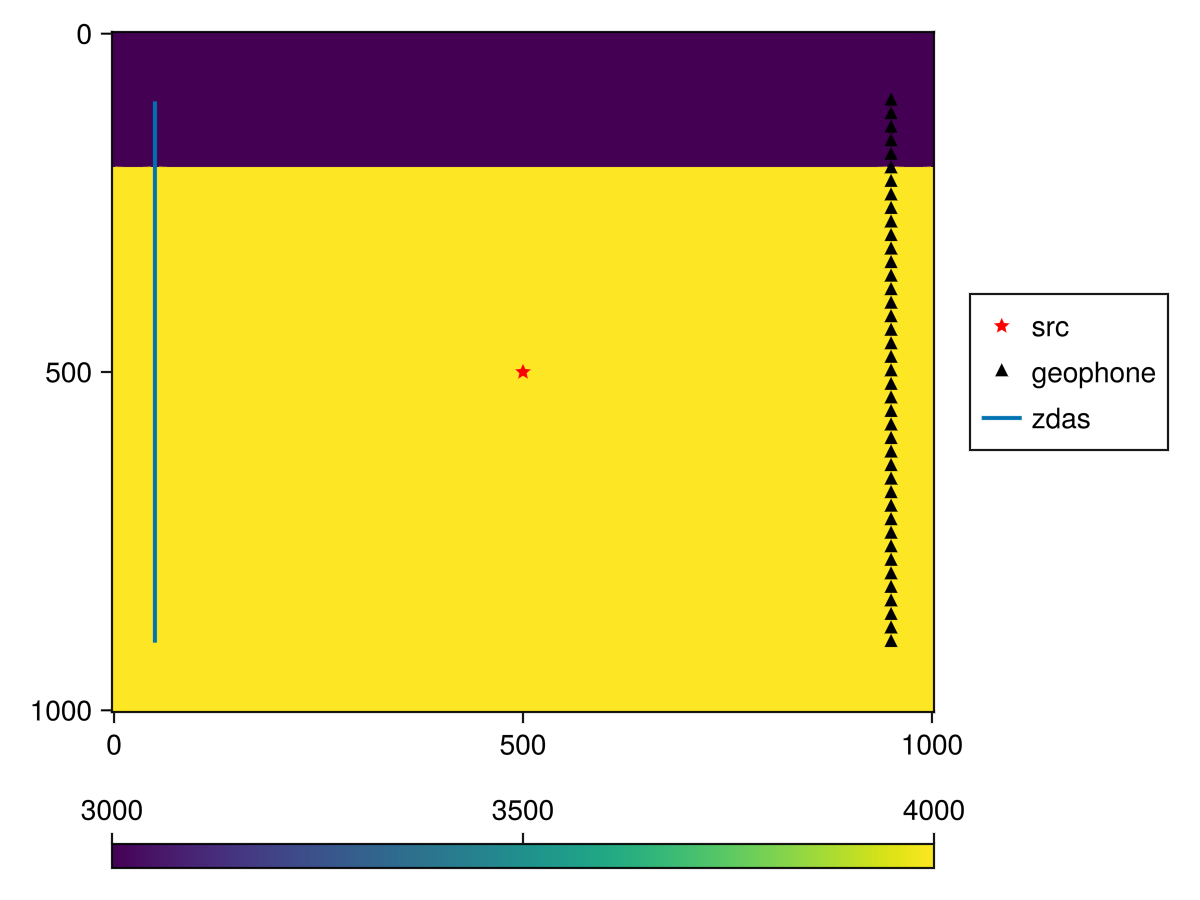

GLMakie.Screen(...)

In [3]:
# source location
source_x = 500
source_z = 500

# lets define a vertical geophone array
geophones = [Dict("x"=>950, "z"=>z) for z in 100:20:900]

# define DAS z-profile accordingly to geophone array. 
das_z = [
    Dict(
        "x" => 50,
        "z" => Dict("start"=>100, "step"=>5, "end"=>900)
    ),
];

# configuration file
config = Dict(
    "settings" => Dict(
        "device" => "cpu",                    # cpu / cuda / metal / amd / intel
        "precision" => "Float32",             # Float64 / Float32
        "spatial_derivative_order" => 4,      # 1-10
        "show_progress_in_console" => true,   # true / false
        "output_file" => RESULTPATH
    ),
    "time" => Dict(
        "start" => 0.0,
        "end" => 0.5,
        "timestep" => 0.5 # will get automatically changed to a stable dt
    ),
    "source" => Dict(
        "dominant_frequency" => 50,
        "wavelet_type" => "ricker",          # ricker / gauss1d
        "wavelet_center" => 0.025,           # >= 1.25/dominant_frequency
        "location" => Dict(
            "x" => source_x,
            "z" => source_z
        ),
        "seismic_moment" => 1e15,
        # a double couple source
        "moment_tensor" => Dict(
            "Mxx" => 1,
            "Mzz" => 1,
            "Mxz" => 0.2,
            "anisotropic" => false
        )
    ),
    "boundaries" => Dict(
        "xstart" => "absorbing",
        "xend" => "absorbing",
        "zstart" => "absorbing",
        "zend" => "absorbing",
        "pml_layer" => 10
    ),
    "receivers" => Dict(
        "geophones" => geophones,
        "das" => Dict(
            "x_aligned" => [],
            "z_aligned" => das_z  
        ),
        "snapshots" => Dict(
            "times" => collect(0:0.01:0.2),           
            "fields" => ["vx", "vz", "sxx"]  
        )
    )
)

# save config file
open(CONFIGPATH, "w") do file
    YAML.write(file, config)
end

# plot source-receivers 
fig = Figure() 
ax = Axis(fig[1,1], yreversed=true)
img = heatmap!(ax, xcoords, zcoords, vp)
src = scatter!(ax, [source_x],[source_z],marker=:star5,color="red")
geo = scatter!(ax, [x["x"] for x in geophones],
                   [z["z"] for z in geophones],
                    marker=:utriangle, color=:black)
vdas = lines!(ax, fill(50, length(100:5:900)), 100:5:900, linewidth=2)
Colorbar(fig[2,1], img, vertical=false)
Legend(fig[1,2], [src, geo,vdas], ["src", "geophone","zdas"])
display(fig)

### Run the simulation

In [4]:
ElasticFDSG.dim2.runsim(CONFIGPATH, VELMODPATH)

┌ Warning: Output /Users/williamtegtow/Library/Mobile Documents/com~apple~CloudDocs/ElasticFDSG/dev/results.h5 already exists. 
│ Once the calculations are complete, this file will be overwritten.
└ @ nothing nothing:nothing
┌ Warning: Given Δt does not satisfy the CFL-stability criterion. Δt changed to 0.00041085983675455607.
└ @ nothing nothing:nothing


╔══════════════════════════════════════════════
║ FDSG 2D - Summary                   
╠══════════════════════════════════════════════
║ System: 
║   Device: cpu                        
║   Approx. Memory: 0.00 GB       
║ Grid: 
║   x: 0.0: 5.0: 1000.0            
║   z: 0.0: 5.0: 1000.0            
║   Number of Nodes: 52441               
║ Time: 
║   Interval: 0.0: 0.00041: 0.49961              
║   Number of Timesteps: 1217           
║ Source: 
║   x,z: 500.0, 500.0            
║   fdom, t0: 50, 0.025           
║ Receiver: 
║   Number of Geophones: 41            
║   Number of Snapshots: 63       
║   Number of Fibers: 0, 1            
╚══════════════════════════════════════════════


Progress: 100%|███████████████████████████| Time: 0:00:01 ( 1.40 ms/it)


Results saved.


### Load Results

In [5]:
# visualize data structure 
ElasticFDSG.print_h5_tree(RESULTFILE)
# load as dictionary 
results = ElasticFDSG.load_results(RESULTFILE);

********************************************************************
H5-File Tree
********************************************************************
└─ Group: das
   ├─ Group: z_aligned
   │  └─ Group: fiber_1
   │     └─ Dataset: data  size=(161, 1217)  eltype=Float32
   │     └─ Dataset: location_xz  size=(161, 2)  eltype=Float32
└─ Group: geophones
   ├─ Group: geophone_1
   │  ├─ Dataset: data  size=(2, 1217)  eltype=Float32
   │  ├─ Dataset: location_xz  size=(2,)  eltype=Float32
   ├─ Group: geophone_10
   │  ├─ Dataset: data  size=(2, 1217)  eltype=Float32
   │  ├─ Dataset: location_xz  size=(2,)  eltype=Float32
   ├─ Group: geophone_11
   │  ├─ Dataset: data  size=(2, 1217)  eltype=Float32
   │  ├─ Dataset: location_xz  size=(2,)  eltype=Float32
   ├─ Group: geophone_12
   │  ├─ Dataset: data  size=(2, 1217)  eltype=Float32
   │  ├─ Dataset: location_xz  size=(2,)  eltype=Float32
   ├─ Group: geophone_13
   │  ├─ Dataset: data  size=(2, 1217)  eltype=Float32
   │  ├─ Dataset:

### Visualize

- Snapshots

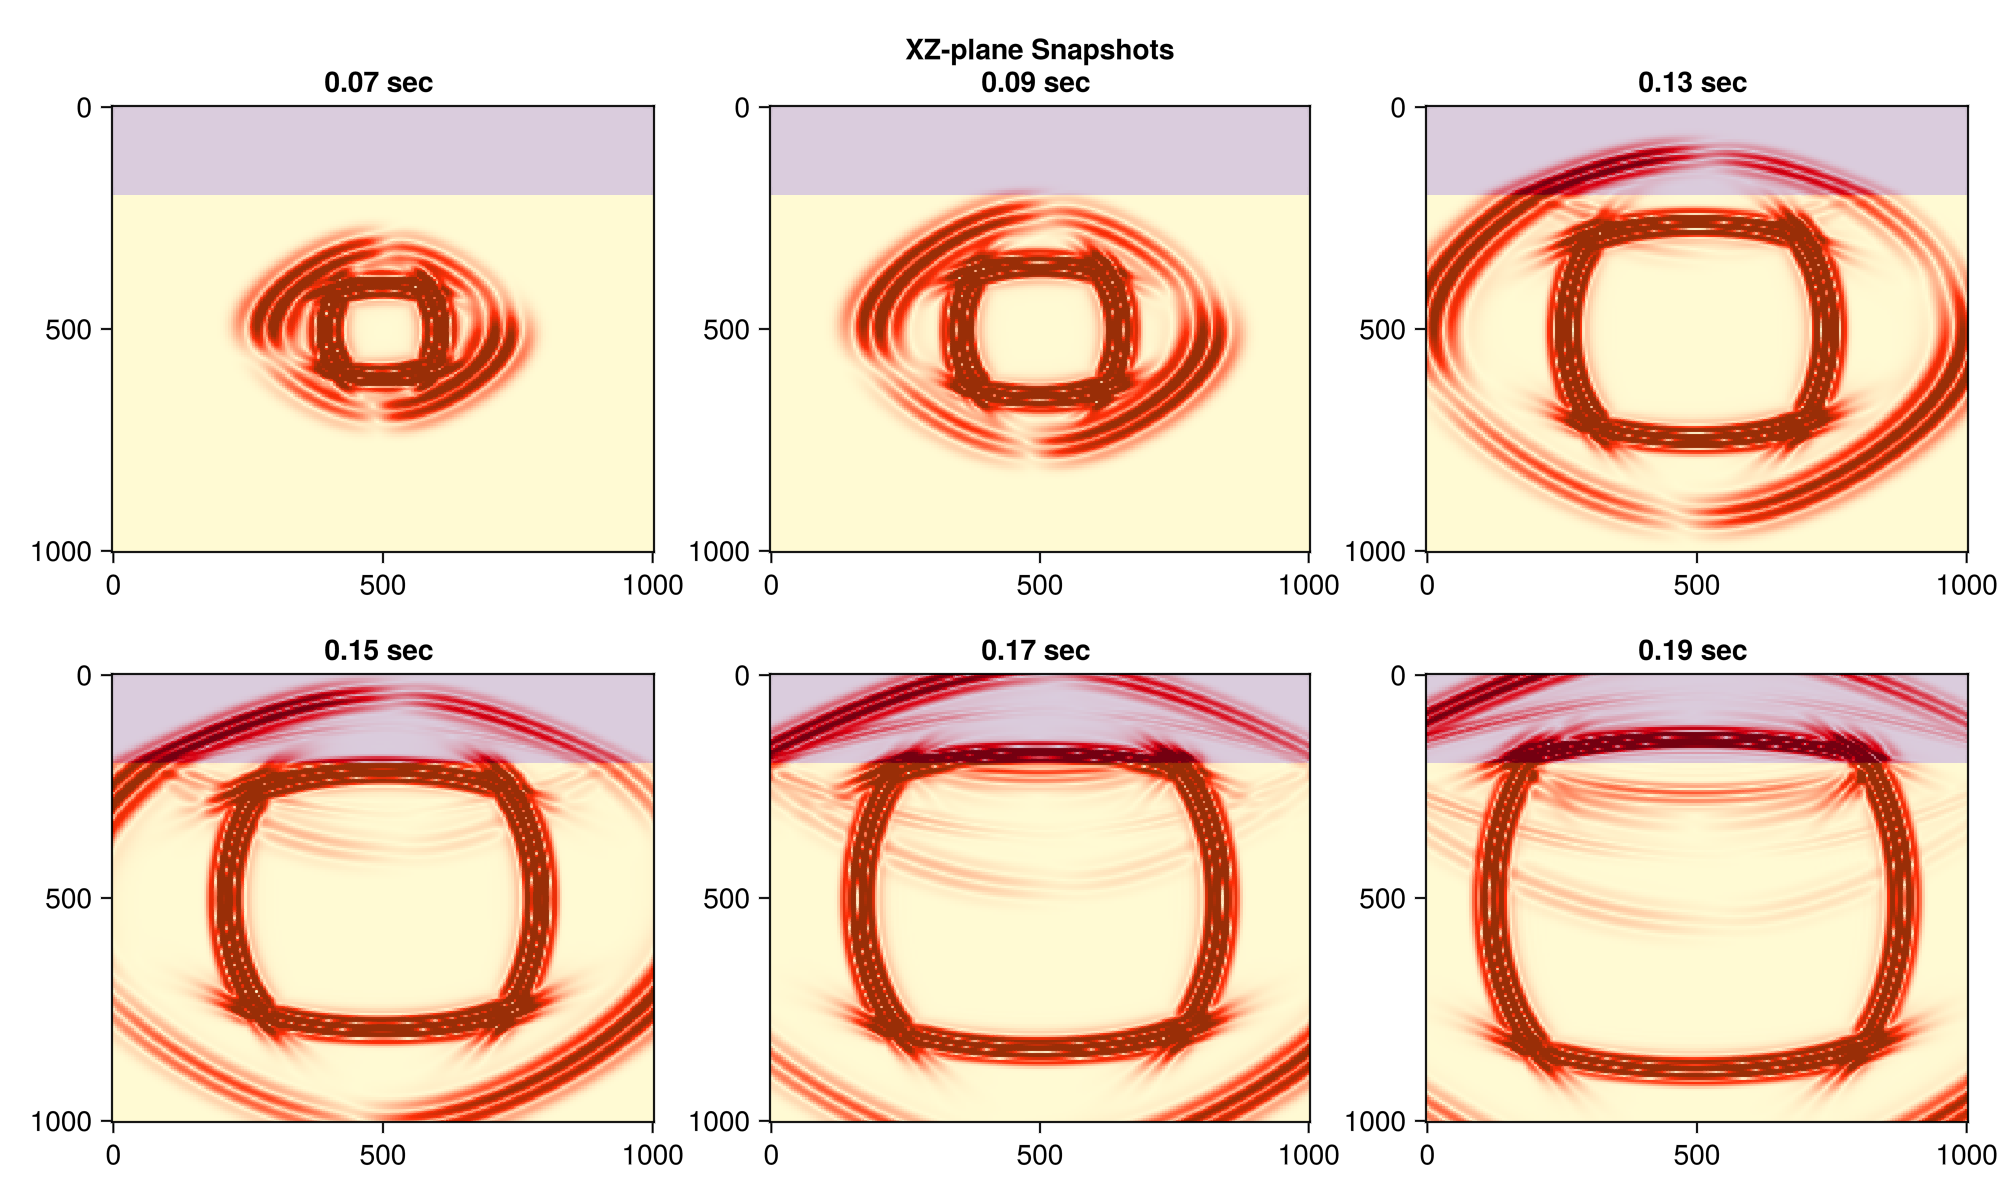

GLMakie.Screen(...)

In [6]:
time = results["time"]["time"]
snapshots = results["snapshots"]
geophones = results["geophones"]
das = results["das"]


snaps_t = snapshots["times"]
snaps_XZ = snapshots["XZ"]
time_ids = [8 10 14; 16 18 20]

fig = Figure(size=(1000,600))
for i in 1:2, j in 1:3
    time_id = time_ids[i,j]
    t = snaps_t[time_id]

    xz = snaps_XZ[time_id, :, :, :]
    # xz[1]->vx, xz[2]->vz 
    ekin = @. 0.5 * sqrt(xz[1,:,:]^2 + xz[2,:,:]^2)
    col = maximum(ekin) / 5
    title = i == 1 && j == 2 ? "XZ-plane Snapshots\n" : ""

    ax = Axis(fig[i,j], title=title*"$(t) sec ", yreversed=true)
    heatmap!(ax, xcoords, zcoords, vp)
    heatmap!(ax, xcoords, zcoords, ekin, colorrange=(-col,col), colormap="seismic", alpha=0.8)
    
end
display(fig)


- Geophones

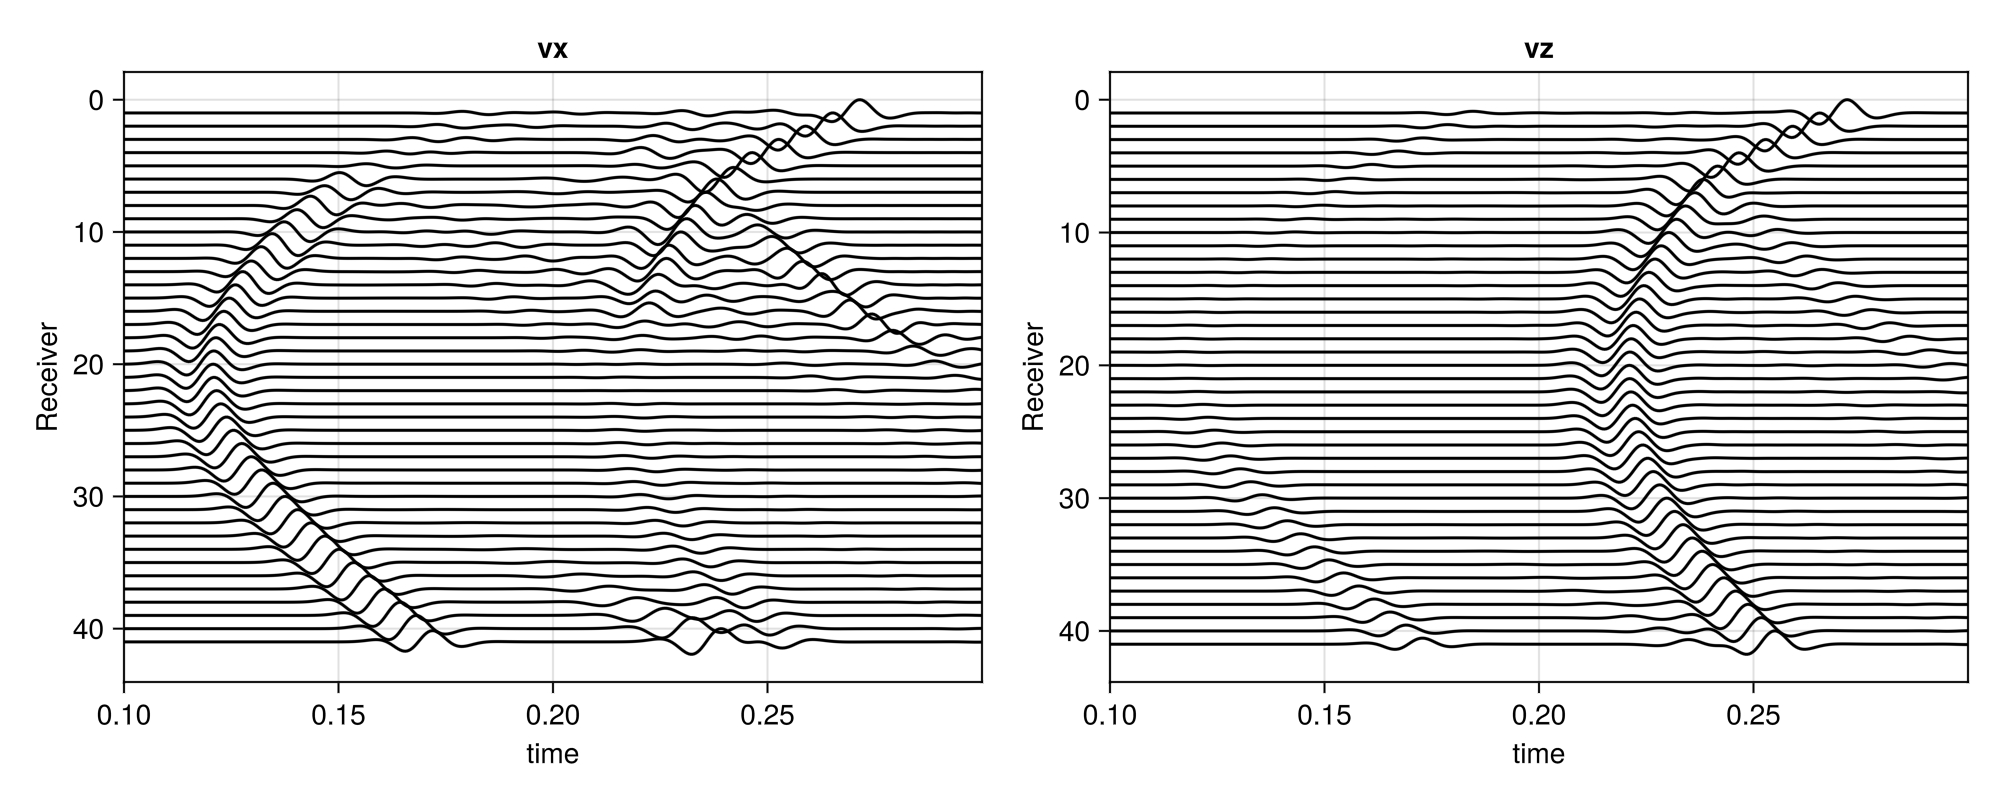

GLMakie.Screen(...)

In [7]:
# geophone array 
function norm11(arr)
    res = arr ./ maximum(abs, arr)
    return res 
end;

fig = Figure(size=(1000, 400)) 
ax1 = Axis(fig[1,1], yreversed=true,title="vx",xlabel="time",ylabel="Receiver")
ax2 = Axis(fig[1,2], yreversed=true,title="vz",xlabel="time",ylabel="Receiver")

for g in 1:length(geophones)
    geo_data = geophones["geophone_$(g)"]["data"]
    
    lines!(ax1, time, norm11(geo_data[1,:]) .+ g, color="black")
    lines!(ax2, time, norm11(geo_data[2,:]) .+ g, color="black")
end   

xlims!(ax1, 0.1, 0.3)
xlims!(ax2, 0.1, 0.3)

display(fig)

- DAS

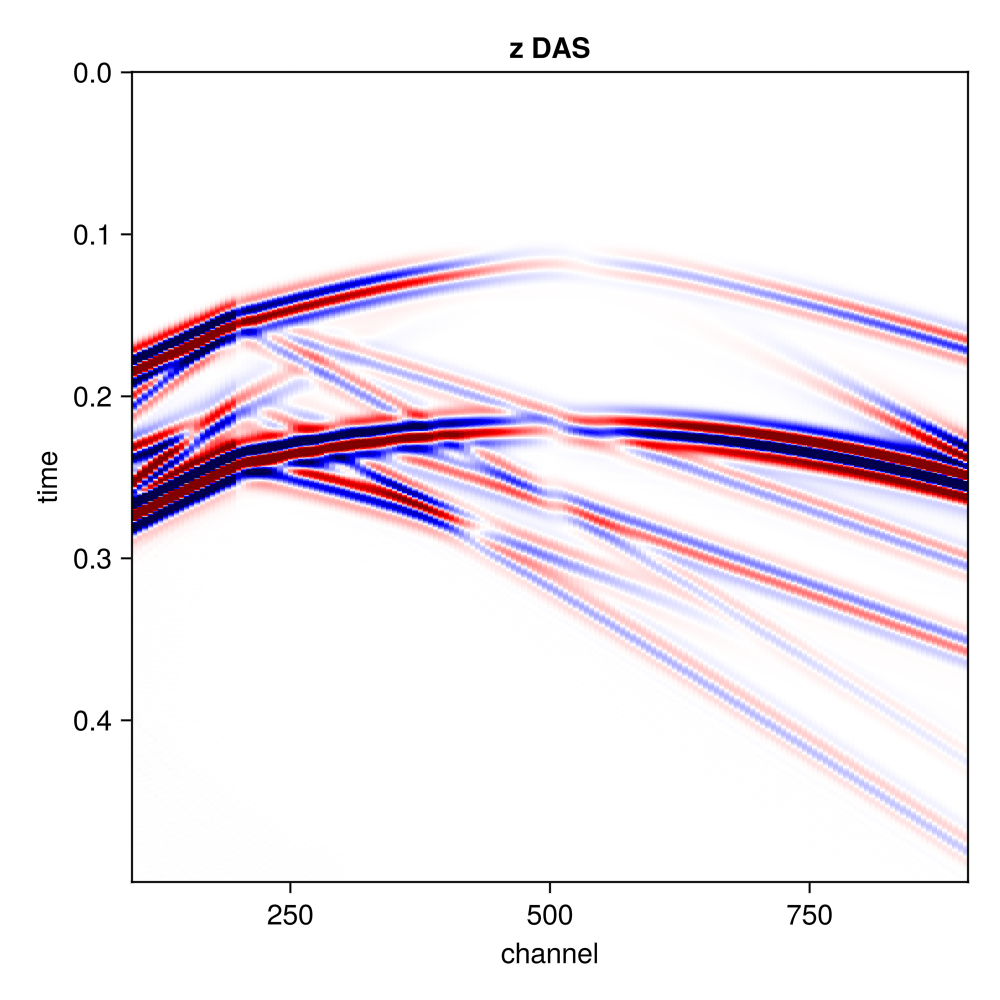

GLMakie.Screen(...)

In [8]:
fig = Figure(size=(500,500)) 
ax = Axis(fig[1,1], yreversed=true, xlabel="channel", ylabel="time", title="z DAS")
z = das["z_aligned"]["fiber_1"]["data"]
zcol = maximum(z) / 5 
heatmap!(ax, 100:5:900, time, z, colorrange=(-zcol,zcol), colormap="seismic")
display(fig)